# Capstone Project
## Probabilistic generative models
### Instructions

In this notebook, you will practice working with generative models, using both normalising flow networks and the variational autoencoder algorithm. You will create a synthetic dataset with a normalising flow with randomised parameters. This dataset will then be used to train a variational autoencoder, and you will used the trained model to interpolate between the generated images. You will use concepts from throughout this course, including Distribution objects, probabilistic layers, bijectors, ELBO optimisation and KL divergence regularisers.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports below. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, callbacks, Model
import random
from tqdm import tqdm
import numpy as np


In [2]:
! pip install matplotlib==3.2.2
import matplotlib.pyplot as plt
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 31.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.2.2-cp38-cp38-macosx_11_0_arm64.whl size=8521246 sha256=0b04471c82e9536a73f7ded69ea0f118db8f1b0efb7f418b662a7851454708d9
  Stored in directory: /Users/thomas.greiner/Library/Caches/pip/wheels/47/1b/58/4a971ec81858b6a8f9c9db74512d662d0950bdaa4f9a3ea797
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2


Fontconfig warning: ignoring UTF-8: not a valid region tag


![Flags overview image](data/example_images.png)

For the capstone project, you will create your own image dataset from contour plots of a transformed distribution using a random normalising flow network. You will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, you will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$. 
* You should use or construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` and `tfb.TransformedDistribution` to construct the final transformed distribution. 
* Ensure to implement the `log_det_jacobian` methods for any subclassed bijectors that you write.
* Display a scatter plot of samples from the base distribution.
* Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of $\theta$ and $a$. Fix the axes of these 4 plots to the range $[-1, 1]$.

In [3]:
# defining the base distribution

# theta~U[0, 2pi] 
thetaDist = tfd.Uniform(low=0, high=2*np.pi)
# a~N(3, 1)
aDist = tfd.Normal(loc=3, scale=1)
mu = np.zeros([1, 2], dtype=np.float32)
sigma = 0.3

# base distribution 2D Normal with diagonal covariance matrix 
baseDist = tfd.Normal(loc=mu, scale=sigma)
baseDist = tfd.Independent(baseDist, reinterpreted_batch_ndims=1)

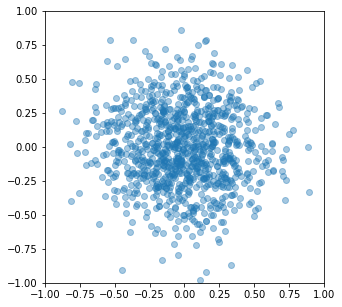

In [4]:
# visualize the base distribution

sampleBaseDist = baseDist.sample(1000).numpy().squeeze()
plt.figure(figsize=(5, 5))
plt.scatter( sampleBaseDist[:,0], sampleBaseDist[:,1] , alpha=0.4)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()


In [5]:
# polynomial class for f3 transformation

class PolynomialTransformation(tfb.Bijector):

    def __init__(self, a=1, name='f_three'):
        super(PolynomialTransformation, self).__init__( forward_min_event_ndims=0, name=name)
        self.a = tf.cast(a, dtype=tf.float32) 
    
    def _forward(self, x):
        x1 = x[..., 0, np.newaxis]
        x2 = x[..., 1, np.newaxis]
        result = tf.concat([x1, x2 + self.a * tf.square(x1)], axis=-1)
        return result
    
    def _inverse(self, y):
        y1 = y[..., 0, np.newaxis]
        y2 = y[..., 1, np.newaxis]
        result = tf.concat([y1, y2 - self.a * tf.square(y1)], axis=-1)
        return result
    
    def _forward_log_det_jacobian(self, x):
        result = tf.constant(0., dtype=x.dtype)
        return result
    
    def _inverse_log_det_jacobian(self, y):
        result = -self._forward_log_det_jacobian(self._inverse(y))
        return result

In [6]:
# rotation matrix class for f4 transformation 

class RotationMatrixTransformation(tfb.Bijector):

    def __init__(self, theta, name='RotationMatrix'):
        self.theta = tf.cast(theta, tf.float32)
        super(RotationMatrixTransformation, self).__init__(forward_min_event_ndims=0, name=name)
        
        self.rotationMatrix = np.array([[np.cos(theta), -np.sin(theta)], 
                                        [np.sin(theta), np.cos(theta)]])

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.linalg.matvec(self.rotationMatrix, x)

    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return tf.linalg.matvec(tf.transpose(self.rotationMatrix), y)

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, dtype=tf.float32)
        return tf.constant(0., dtype=tf.float32)
    
    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(self._inverse(y))


In [7]:
# create the chain of transformations 𝑥=𝑓5(𝑓4(𝑓3(𝑓2(𝑓1(𝑧))))) 

def chainOfTransformations(a, theta):
    f1 = tfb.Shift([0., -2.])
    f2 = tfb.Scale(scale=[1, 0.5])
    f3 = PolynomialTransformation(a)
    f4 = RotationMatrixTransformation(theta)
    f5 = tfb.Tanh()
    return tfb.Chain([f5, f4, f3, f2, f1])


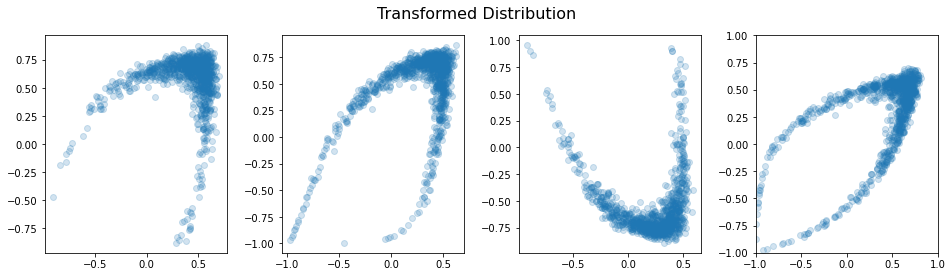

In [8]:
# visualize the transformation

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()
plt.suptitle('Transformed Distribution', fontsize=16)
for i in range(4):
    transformed_samples = chainOfTransformations(aDist.sample(), thetaDist.sample())(baseDist).sample(1000)
    ax[i].scatter(transformed_samples[..., 0], transformed_samples[..., 1], alpha=0.2)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
plt.subplots_adjust(wspace=0.3)    
plt.show()



## 2. Create the image dataset
* You should now use your random normalising flow to generate an image dataset of contour plots from your random normalising flow network. 
  * Feel free to get creative and experiment with different architectures to produce different sets of images!
* First, display a sample of 4 contour plot images from your normalising flow network using 4 independently sampled sets of parameters. 
  * You may find the following `get_densities` function useful: this calculates density values for a (batched) Distribution for use in a contour plot. 
* Your dataset should consist of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$. It will take a few minutes to create the dataset.
* As well as the `get_densities` function, the `get_image_array_from_density_values` function will help you to generate the dataset. 
  * This function creates a numpy array for an image of the contour plot for a given set of density values Z. Feel free to choose your own options for the contour plots.
* Display a sample of 20 images from your generated dataset in a figure.

In [9]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [10]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

In [11]:
# creating the density values Z
Z = []
for ix in range(4):
    transformedBijector = chainOfTransformations(aDist.sample(), thetaDist.sample())
    transformedDist = tfd.TransformedDistribution(baseDist, bijector=transformedBijector)
    Z.append(np.squeeze(get_densities(transformedDist)))

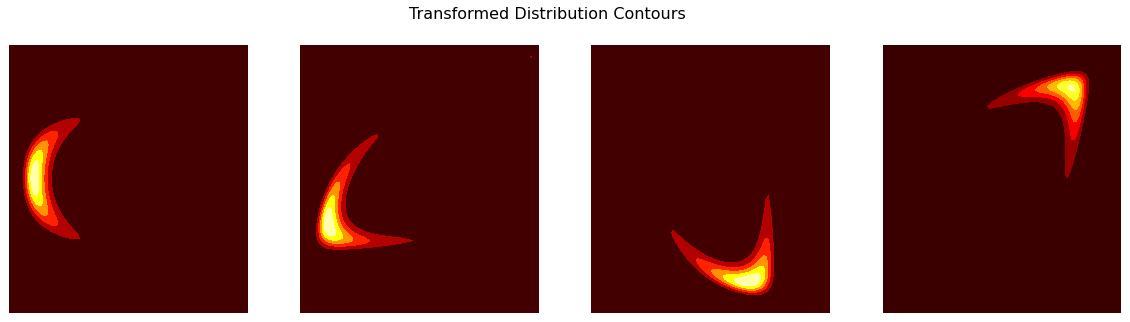

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()
plt.suptitle('Transformed Distribution Contours', fontsize=16)
for i in range(4):
    ax[i].contourf(X, Y, Z[i], cmap="hot")
    ax[i].axis("off")
plt.show();

In [13]:
# creating the images from the randomly sampled density values
images = []
N = 2000
for i in tqdm(range(N)):
    transformedBijector = chainOfTransformations(aDist.sample(), thetaDist.sample())
    transformedDist = tfd.TransformedDistribution(baseDist, bijector=transformedBijector)
    image = get_image_array_from_density_values(get_densities(transformedDist).squeeze())
    images.append(image)

100%|██████████| 2000/2000 [01:36<00:00, 20.65it/s]


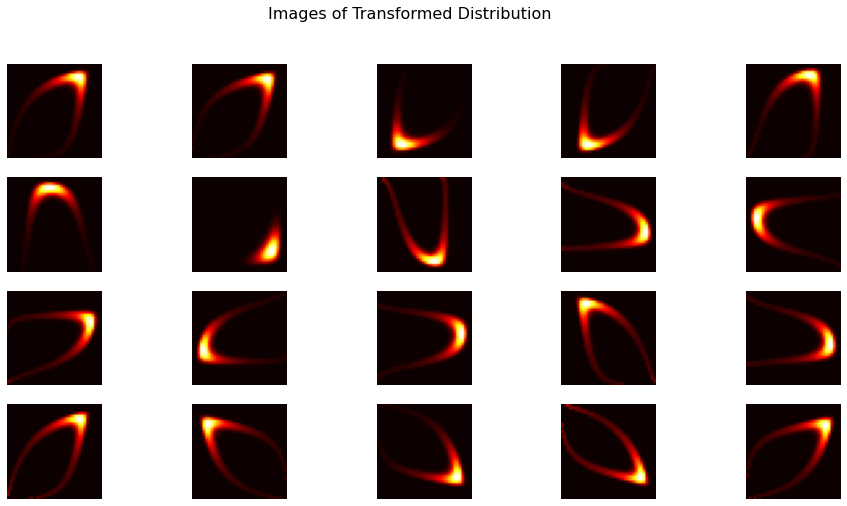

In [14]:
indx = list(np.random.choice(range(N), 20, replace=False))
rows, cols = 4, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 8)) 
plt.suptitle('Images of Transformed Distribution', fontsize=16)
i = 0
for row in range(rows):
    for col in range(cols):
        ax[row,col].imshow(images[indx[i]])
        ax[row,col].margins(0)
        ax[row,col].axis("off")
        i += 1
plt.show();

## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data. 
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [15]:
# creating training and validation dataset for training the VAE
trainDat, valDat = train_test_split(images, test_size=0.1)

trainDat = tf.data.Dataset.from_tensor_slices(trainDat)
valDat = tf.data.Dataset.from_tensor_slices(valDat)

trainDat = trainDat.map(lambda x: tf.cast(x, tf.float32)/255.)
valDat = valDat.map(lambda x: tf.cast(x, tf.float32)/255.)

trainDat = trainDat.map(lambda x: (x, x))
valDat = valDat.map(lambda x: (x, x))

trainDat = trainDat.shuffle(buffer_size=len(images))

trainDat = trainDat.batch(20, drop_remainder=True)
valDat = valDat.batch(20, drop_remainder=True)

In [16]:
print(trainDat.element_spec)
print(valDat.element_spec)

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


## 4. Build the encoder and decoder networks
* You should now create the encoder and decoder for the variational autoencoder algorithm.
* You should design these networks yourself, subject to the following constraints:
   * The encoder and decoder networks should be built using the `Sequential` class.
   * The encoder and decoder networks should use probabilistic layers where necessary to represent distributions.
   * The prior distribution should be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network should add the KL divergence loss to the model.
* Print the model summary for the encoder and decoder networks.

In [17]:
latentSize = 10
eventShape = (36, 36, 3)
prior = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.zeros(latentSize), dtype=tf.float32),
                                   scale_diag=tf.ones(latentSize, dtype=tf.float32))

In [18]:
def getklRegularizer(prior):
    return tfpl.KLDivergenceRegularizer(prior,
                                        weight=0.8,
                                        use_exact_kl=False,
                                        test_points_fn=lambda q: q.sample(5),
                                        test_points_reduce_axis=None)

In [19]:
# defining the encoder
def getEncoder(klRegularizer, eventShape=eventShape, latentSize=latentSize):
    encoder = models.Sequential()
    encoder.add(layers.Conv2D(16, (3,3), strides=2, padding='same', activation='relu', input_shape=eventShape))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu'))
    encoder.add(layers.BatchNormalization()),
    encoder.add(layers.Conv2D(128, (3,3), strides=2, padding='same', activation='relu'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(tfpl.MultivariateNormalTriL.params_size(latentSize)))
    encoder.add(tfpl.MultivariateNormalTriL(latentSize, activity_regularizer=klRegularizer))
                
    return encoder

In [20]:
klDivergenceRegularizer = getklRegularizer(prior)
encoder = getEncoder(klRegularizer=klDivergenceRegularizer, eventShape=eventShape, latentSize=latentSize)
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 18, 18, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 32)          4640      
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 32)         128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          18496     
                                                                 
 batch_normalization_2 (Batc  (None, 5, 5, 64)         2

2022-09-02 16:09:43.676502: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [21]:
# defining the decoder 
def getDecoder(eventShape=eventShape , latentSize=latentSize):
    decoder = models.Sequential()
    decoder.add(layers.Dense(9*9*128, activation='relu', input_shape=(latentSize,)))
    decoder.add(layers.Reshape((9,9,128))) #9x9
    decoder.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    decoder.add(layers.UpSampling2D(size=(2,2))) #18x18
    decoder.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    decoder.add(layers.UpSampling2D(size=(2,2))) #36x36
    decoder.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    decoder.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    decoder.add(layers.Conv2D(3, (1,1), padding='same', activation='linear'))
    decoder.add(layers.Flatten())
    decoder.add(tfpl.IndependentBernoulli(eventShape))
    
    return decoder

In [22]:
decoder = getDecoder(eventShape, latentSize)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10368)             114048    
                                                                 
 reshape (Reshape)           (None, 9, 9, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 64)          73792     
                                                                 
 up_sampling2d (UpSampling2D  (None, 18, 18, 64)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 32)        18464     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 36, 36, 32)       0         
 2D)                                                  

## 5. Train the variational autoencoder
* You should now train the variational autoencoder. Build the VAE using the `Model` class and the encoder and decoder models. Print the model summary.
* Compile the VAE with the negative log likelihood loss and train with the `fit` method, using the training and validation Datasets.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [23]:
# defining the negative log likelihood reconstrution loss
def reconstructionLoss(batchOfImages, decodingDist):
    return - tf.reduce_mean(decodingDist.log_prob(batchOfImages)) 

In [24]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 36, 36, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 18, 18, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 18, 18, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 32)          4640      
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 32)         128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          18496 

In [25]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer, loss=reconstructionLoss)

In [26]:
# defining a callback for early stopping (avoid overtraining and possible over-fitting)
callBack = callbacks.EarlyStopping(monitor="val_loss", 
                                   min_delta=1, 
                                   patience=4, 
                                   restore_best_weights=True)

In [27]:
# fitting the model to the training data
history = vae.fit(trainDat, 
                  validation_data=valDat,
                  epochs=20,
                  callbacks=[callBack])

Epoch 1/20


2022-09-02 16:10:07.472971: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


90/90 [==============================] - 4s 36ms/step - loss: 794.2672 - val_loss: 1007.1108
Epoch 2/20
90/90 [==============================] - 3s 36ms/step - loss: 430.2581 - val_loss: 719.2607
Epoch 3/20
90/90 [==============================] - 3s 38ms/step - loss: 394.2645 - val_loss: 552.6801
Epoch 4/20
90/90 [==============================] - 3s 38ms/step - loss: 383.0494 - val_loss: 453.8548
Epoch 5/20
90/90 [==============================] - 3s 37ms/step - loss: 377.3937 - val_loss: 398.3442
Epoch 6/20
90/90 [==============================] - 4s 40ms/step - loss: 373.9575 - val_loss: 377.5982
Epoch 7/20
90/90 [==============================] - 4s 40ms/step - loss: 372.4110 - val_loss: 370.4725
Epoch 8/20
90/90 [==============================] - 3s 38ms/step - loss: 371.4789 - val_loss: 367.6320
Epoch 9/20
90/90 [==============================] - 3s 39ms/step - loss: 366.2726 - val_loss: 368.4126
Epoch 10/20
90/90 [==============================] - 4s 40ms/step - loss: 366.9841 

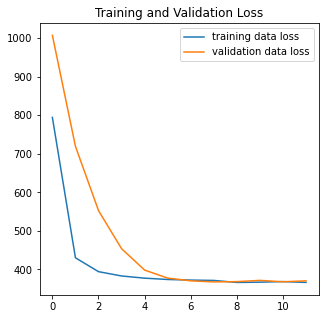

In [28]:
# visualize the loss
plt.figure(figsize=(5, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.legend(["training data loss", "validation data loss"])
plt.show()

## 6. Use the encoder and decoder networks
* You can now put your encoder and decoder networks into practice!
* Randomly sample 1000 images from the dataset, and pass them through the encoder. Display the embeddings in a scatter plot (project to 2 dimensions if the latent space has dimension higher than two).
* Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.
  * Use the mean of the output distribution to display the images.
* Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.
  * Again use the mean of the output distribution to display the images.

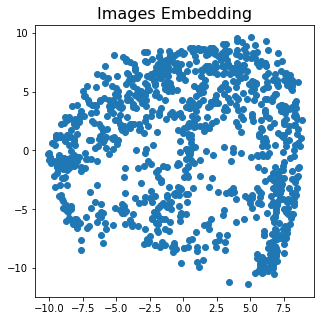

In [29]:
# extract samples to visualize the 2D embedding from the 10-dim latent space/representation  
indx = list(np.random.choice(range(N), 1000, replace=False))
samples = np.array([images[indx[x]]/255. for x in range(1000)])
latentRep = encoder.predict(samples)
plt.figure(figsize=(5, 5))
plt.scatter(latentRep[..., 0], latentRep[..., 1])
plt.title("Images Embedding", fontsize=16)
plt.show();

In [30]:
sample = random.sample(images, k=6)
sample = [x/255.0 for x in sample]
sample = np.array(sample)
reconstructions = decoder(encoder(sample).mean()).mean()

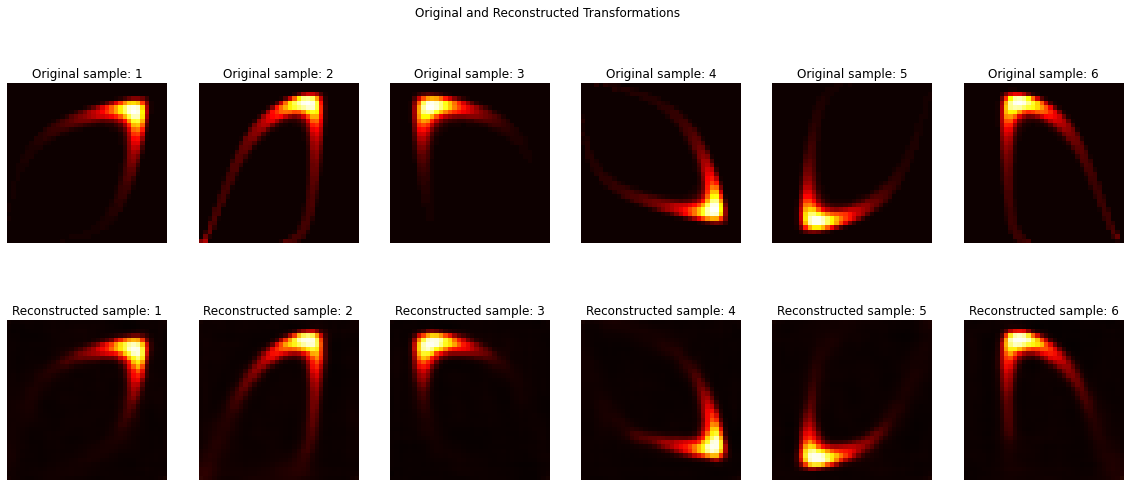

In [31]:
cols = 6
fig, ax = plt.subplots(nrows=2, ncols=cols, figsize=(20, 8))
plt.suptitle('Original and Reconstructed Transformations', fontsize=12)
i = 0
for col in range(cols):
    ax[0,col].title.set_text('Original sample: {}'.format(i+1))
    ax[0,col].imshow(sample[i])
    ax[0,col].axis("off")
    ax[1,col].title.set_text('Reconstructed sample: {}'.format(i+1))
    ax[1,col].imshow(reconstructions[i])
    ax[1,col].axis("off")
    i += 1
plt.show();


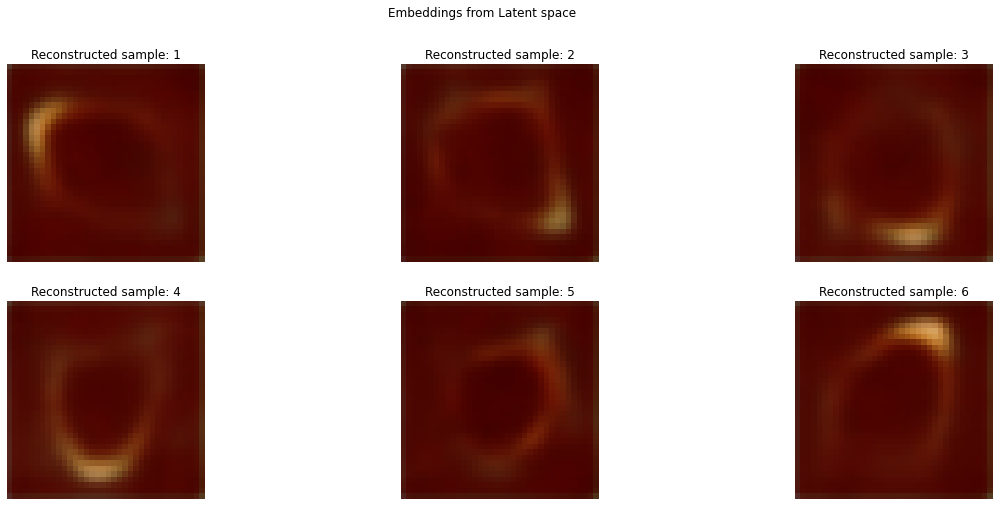

In [41]:
# Random Latent Space Embedding Visualization

N = 6
embeddings = np.random.uniform(-1, 1, (N, latentSize))
latentReconstructions = decoder(embeddings).mean()
rows, cols = 2, 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 8))
plt.suptitle('Embeddings from Latent space', fontsize=12)
i = 0
for row in range(rows):
    for col in range(cols):
        ax[row,col].title.set_text('Reconstructed sample: {}'.format(i+1))
        ax[row,col].imshow(latentReconstructions[i])
        ax[row,col].axis("off")
        i += 1
plt.show();

## Make a video of latent space interpolation (not assessed)
* Just for fun, you can run the code below to create a video of your decoder's generations, depending on the latent space.

In [107]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

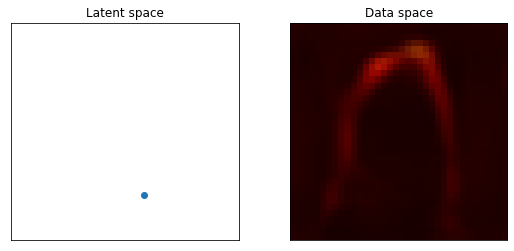

In [111]:
# Create the animation

a = get_animation(latentSize, decoder, interpolation_length=200)
HTML(a.to_html5_video())